# Let's enjoy more on TensorFlow to figure out how it works

# Test Prediction with LSTM

In [2]:
% matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

from tensorflow.contrib import learn
from sklearn.metrics import mean_squared_error
    

In [3]:
x = np.arange(0, 10, 0.01)
y = x * np.sin(x)

In [4]:
x = x.reshape(len(x), 1)
y = y.reshape(len(y), 1)

In [5]:
class LSTM(object):
    def __init__(self, N_in, N_hidden, N_out, N_memory, learning_rate, is_initialize=False):
        self.N_in = N_in
        self.N_hidden = N_hidden
        self.N_out = N_out
        self.N_memory = N_memory
        
        if is_initialize:
            sess = tf.InteractiveSession()
            tf.reset_default_graph() # reset the graph under sess
            sess.close()
        
        self.x = tf.placeholder(tf.float32, [N_memory, N_in])
        x_tilde = [tf.reshape(self.x[i, :], [1, N_in]) for i in xrange(N_memory)]
        self.y = tf.placeholder(tf.float32, [N_memory, N_out])
        
        W_value = tf.truncated_normal([N_hidden, N_out], stddev=0.1)
        self.W = tf.Variable(W_value)
        b_value = tf.constant(0.0, N_out)
        self.b = tf.Variable(b_value)
        
        self.cell = cell = tf.nn.rnn_cell.BasicLSTMCell(N_hidden)
        self._initial_state = cell.zero_state(1, tf.float32)
        state = self._initial_state
        cell_outputs, state = tf.nn.rnn(cell, inputs=x_tilde, initial_state=state)
        self._final_state = state
        cell_outputs = tf.pack(cell_outputs)
        pre_outputs = tf.squeeze(cell_outputs, [1])
        self.outputs = tf.matmul(pre_outputs, self.W) + self.b
        # training    
        self.loss = tf.reduce_mean(tf.square(self.outputs - self.y))
        optimizer = tf.train.AdamOptimizer(learning_rate)
        self.train = optimizer.minimize(self.loss)
        
    def online_predict(self, input_data, target_data, N_epochs=1000):
        pred_input = tf.placeholder(tf.float32, [1, N_in])
        pre_out, state = self.cell(inputs=pred_input, state=self._final_state)
        prediction = tf.matmul(pre_out, self.W) + self.b
        N_data = len(input_data)
        print_freq = int(N_epochs / 10)
        outputs_list = []
        with tf.Session() as sess:
            tf.initialize_all_variables().run()
            for end in xrange(self.N_memory, N_data):
                beg = end - self.N_memory
                train_x = input_data[beg: end]
                pred_x = [input_data[end]]
                train_y = target_data[beg: end]
                for i in xrange(N_epochs):
                    sess.run(self.train, feed_dict={self.x: train_x, self.y: train_y})
                    # if i%10 == 0:
                    #    print ("loss = %e" % self.loss.eval(session=sess, feed_dict={self._input: train_x, self._target: train_y}))
                print ("predict %d, loss = %e" % (end, self.loss.eval(session=sess, feed_dict={self.x: train_x, self.y: train_y})))
                prediction_value = prediction.eval(session=sess, feed_dict={self.x: train_x, pred_input: pred_x})[0]
                outputs_list.append(prediction_value)
        return outputs_list
        
        
        

In [6]:
import time


N_memory = 10
N_in = 1
N_hidden = 1
N_out = 1

st = time.time()
lstm = LSTM(N_in, N_hidden, N_out, N_memory, learning_rate=1e-3, is_initialize=True)

prediction = lstm.online_predict(x, y, N_epochs=100)
print ("elapsed:", time.time() - st)

InternalError: Blas SGEMM launch failed : a.shape=(1, 2), b.shape=(2, 4), m=1, n=4, k=2
	 [[Node: RNN/BasicLSTMCell/Linear/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/gpu:0"](RNN/BasicLSTMCell/Linear/concat, RNN/BasicLSTMCell/Linear/Matrix/read)]]
Caused by op u'RNN/BasicLSTMCell/Linear/MatMul', defined at:
  File "/home/tomoaki/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/tomoaki/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-4538641c6b50>", line 10, in <module>
    lstm = LSTM(N_in, N_hidden, N_out, N_memory, learning_rate=1e-3, is_initialize=True)
  File "<ipython-input-5-08bd1301ce56>", line 25, in __init__
    cell_outputs, state = tf.nn.rnn(cell, inputs=x_tilde, initial_state=state)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/rnn.py", line 216, in rnn
    (output, state) = call_cell()
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/rnn.py", line 203, in <lambda>
    call_cell = lambda: cell(input_, state)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/rnn_cell.py", line 298, in __call__
    concat = _linear([inputs, h], 4 * self._num_units, True)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/rnn_cell.py", line 885, in _linear
    res = math_ops.matmul(array_ops.concat(1, args), matrix)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/math_ops.py", line 1346, in matmul
    name=name)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1271, in _mat_mul
    transpose_b=transpose_b, name=name)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 703, in apply_op
    op_def=op_def)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2298, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1232, in __init__
    self._traceback = _extract_stack()


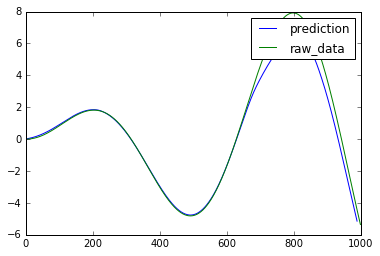

In [39]:
plt.plot(prediction, label="prediction")
plt.plot(y, label="raw_data")
plt.legend()